In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from pingouin import partial_corr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import random
from catboost import CatBoostRegressor
random.seed(42)

tfc1_dual_encoder_features_path = '/mnt/qb/work/eickhoff/esx208/MechIR/data/patching_unnormalised/sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco_bi_TFC1_4000_batch_size_20_features.tsv'
tfc1_cross_encoder_features_path = '/mnt/qb/work/eickhoff/esx208/MechIR/data/patching_unnormalised/crystina-z-monoELECTRA_LCE_nneg31_cross_TFC1_4000_batch_size_20_features.tsv'

Matplotlib created a temporary cache directory at /scratch_local/esx208-1181477/tmp/matplotlib-waxfz9ii because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
feature_table_dual_encoder = pd.read_csv(tfc1_dual_encoder_features_path, sep='\t')
feature_table_cross_encoder = pd.read_csv(tfc1_cross_encoder_features_path, sep='\t')

In [3]:
features = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'injected_term_token_len', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
            'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
            'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
            'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']

In [4]:
target_features = ['patching_effect_std', 'patching_effect_absolute_mean', 'patching_effect_normalised_std', 'patching_effect_normalised_absolute_mean', 'patching_effect_normalised_square_std', 'patching_effect_normalised_square_absolute_mean']

In [5]:
def output_correlations(properties, target_metrics, data):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            spearman = spearmanr(data[property], data[target_metric])
            kendall = kendalltau(data[property], data[target_metric])
            correlations[target_metric][property] = {'spearman': np.round(spearman.correlation, 3), 
                                                     'p-value-spearman': np.round(spearman.pvalue, 3),
                                                     'kendalltau': np.round(kendall.correlation, 3),
                                                     'p-value-kendalltau': np.round(kendall.pvalue, 3)}
    return pd.DataFrame(correlations)


def output_partial_correlations(properties, target_metrics, data, features_to_control = ['score_delta']):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            if property not in features_to_control:
                spearman_partial = partial_corr(data=data, x=target_metric, y=property, covar=features_to_control, method='spearman')
                correlations[target_metric][property] = {'spearman_partial': np.round(spearman_partial['r'].values[0], 3), 
                                                        'p-value': np.round(spearman_partial['p-val'].values[0], 3)}
    return pd.DataFrame(correlations)

In [6]:
output_correlations(features, target_features, feature_table_dual_encoder)

/scratch_local/esx208-1181477/tmp/ipykernel_1992228/285442413.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(data[property], data[target_metric])


,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean
score_delta,"{'spearman': 0.905, 'p-value-spearman': 0.0, '...","{'spearman': 0.934, 'p-value-spearman': 0.0, '...","{'spearman': -0.77, 'p-value-spearman': 0.0, '...","{'spearman': -0.847, 'p-value-spearman': 0.0, ...","{'spearman': 0.006, 'p-value-spearman': 0.705,...","{'spearman': -0.128, 'p-value-spearman': 0.0, ..."
relevance,"{'spearman': -0.702, 'p-value-spearman': 0.0, ...","{'spearman': -0.722, 'p-value-spearman': 0.0, ...","{'spearman': 0.622, 'p-value-spearman': 0.0, '...","{'spearman': 0.675, 'p-value-spearman': 0.0, '...","{'spearman': 0.042, 'p-value-spearman': 0.007,...","{'spearman': 0.148, 'p-value-spearman': 0.0, '..."
tfidf_injected_term,"{'spearman': -0.38, 'p-value-spearman': 0.0, '...","{'spearman': -0.384, 'p-value-spearman': 0.0, ...","{'spearman': 0.565, 'p-value-spearman': 0.0, '...","{'spearman': 0.657, 'p-value-spearman': 0.0, '...","{'spearman': 0.213, 'p-value-spearman': 0.0, '...","{'spearman': 0.366, 'p-value-spearman': 0.0, '..."
idf_injected_term,"{'spearman': 0.602, 'p-value-spearman': 0.0, '...","{'spearman': 0.605, 'p-value-spearman': 0.0, '...","{'spearman': -0.334, 'p-value-spearman': 0.0, ...","{'spearman': -0.358, 'p-value-spearman': 0.0, ...","{'spearman': 0.074, 'p-value-spearman': 0.0, '...","{'spearman': -0.013, 'p-value-spearman': 0.405..."
tf_injected_term,"{'spearman': -0.466, 'p-value-spearman': 0.0, ...","{'spearman': -0.468, 'p-value-spearman': 0.0, ...","{'spearman': 0.551, 'p-value-spearman': 0.0, '...","{'spearman': 0.651, 'p-value-spearman': 0.0, '...","{'spearman': 0.112, 'p-value-spearman': 0.0, '...","{'spearman': 0.264, 'p-value-spearman': 0.0, '..."
injected_term_token_len,"{'spearman': 0.502, 'p-value-spearman': 0.0, '...","{'spearman': 0.516, 'p-value-spearman': 0.0, '...","{'spearman': -0.203, 'p-value-spearman': 0.0, ...","{'spearman': -0.2, 'p-value-spearman': 0.0, 'k...","{'spearman': 0.14, 'p-value-spearman': 0.0, 'k...","{'spearman': 0.105, 'p-value-spearman': 0.0, '..."
tfidf_mean,"{'spearman': 0.247, 'p-value-spearman': 0.0, '...","{'spearman': 0.271, 'p-value-spearman': 0.0, '...","{'spearman': -0.083, 'p-value-spearman': 0.0, ...","{'spearman': -0.071, 'p-value-spearman': 0.0, ...","{'spearman': 0.124, 'p-value-spearman': 0.0, '...","{'spearman': 0.158, 'p-value-spearman': 0.0, '..."
tfidf_std,"{'spearman': 0.108, 'p-value-spearman': 0.0, '...","{'spearman': 0.111, 'p-value-spearman': 0.0, '...","{'spearman': -0.057, 'p-value-spearman': 0.0, ...","{'spearman': -0.073, 'p-value-spearman': 0.0, ...","{'spearman': 0.009, 'p-value-spearman': 0.557,...","{'spearman': -0.014, 'p-value-spearman': 0.391..."
english_probability,"{'spearman': 0.001, 'p-value-spearman': 0.954,...","{'spearman': -0.005, 'p-value-spearman': 0.735...","{'spearman': 0.001, 'p-value-spearman': 0.973,...","{'spearman': -0.01, 'p-value-spearman': 0.523,...","{'spearman': 0.003, 'p-value-spearman': 0.839,...","{'spearman': -0.009, 'p-value-spearman': 0.583..."
flesch_reading_ease,"{'spearman': -0.026, 'p-value-spearman': 0.102...","{'spearman': -0.04, 'p-value-spearman': 0.011,...","{'spearman': -0.005, 'p-value-spearman': 0.737...","{'spearman': -0.029, 'p-value-spearman': 0.064...","{'spearman': -0.066, 'p-value-spearman': 0.0, ...","{'spearman': -0.107, 'p-value-spearman': 0.0, ..."


In [7]:
output_partial_correlations(features, target_features, feature_table_dual_encoder)

/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scra

,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean
relevance,"{'spearman_partial': -0.062, 'p-value': 0.0}","{'spearman_partial': -0.063, 'p-value': 0.0}","{'spearman_partial': 0.095, 'p-value': 0.0}","{'spearman_partial': 0.098, 'p-value': 0.0}","{'spearman_partial': 0.072, 'p-value': 0.0}","{'spearman_partial': 0.079, 'p-value': 0.0}"
tfidf_injected_term,"{'spearman_partial': 0.271, 'p-value': 0.0}","{'spearman_partial': 0.364, 'p-value': 0.0}","{'spearman_partial': 0.292, 'p-value': 0.0}","{'spearman_partial': 0.464, 'p-value': 0.0}","{'spearman_partial': 0.254, 'p-value': 0.0}","{'spearman_partial': 0.354, 'p-value': 0.0}"
idf_injected_term,"{'spearman_partial': 0.359, 'p-value': 0.0}","{'spearman_partial': 0.388, 'p-value': 0.0}","{'spearman_partial': 0.124, 'p-value': 0.0}","{'spearman_partial': 0.185, 'p-value': 0.0}","{'spearman_partial': 0.083, 'p-value': 0.0}","{'spearman_partial': 0.063, 'p-value': 0.0}"
tf_injected_term,"{'spearman_partial': 0.177, 'p-value': 0.0}","{'spearman_partial': 0.262, 'p-value': 0.0}","{'spearman_partial': 0.198, 'p-value': 0.0}","{'spearman_partial': 0.365, 'p-value': 0.0}","{'spearman_partial': 0.142, 'p-value': 0.0}","{'spearman_partial': 0.235, 'p-value': 0.0}"
injected_term_token_len,"{'spearman_partial': 0.358, 'p-value': 0.0}","{'spearman_partial': 0.434, 'p-value': 0.0}","{'spearman_partial': 0.18, 'p-value': 0.0}","{'spearman_partial': 0.286, 'p-value': 0.0}","{'spearman_partial': 0.15, 'p-value': 0.0}","{'spearman_partial': 0.172, 'p-value': 0.0}"
tfidf_mean,"{'spearman_partial': 0.134, 'p-value': 0.0}","{'spearman_partial': 0.21, 'p-value': 0.0}","{'spearman_partial': 0.128, 'p-value': 0.0}","{'spearman_partial': 0.207, 'p-value': 0.0}","{'spearman_partial': 0.125, 'p-value': 0.0}","{'spearman_partial': 0.191, 'p-value': 0.0}"
tfidf_std,"{'spearman_partial': 0.058, 'p-value': 0.0}","{'spearman_partial': 0.07, 'p-value': 0.0}","{'spearman_partial': 0.022, 'p-value': 0.172}","{'spearman_partial': 0.01, 'p-value': 0.522}","{'spearman_partial': 0.009, 'p-value': 0.579}","{'spearman_partial': -0.002, 'p-value': 0.912}"
english_probability,"{'spearman_partial': -0.006, 'p-value': 0.721}","{'spearman_partial': -0.025, 'p-value': 0.12}","{'spearman_partial': 0.005, 'p-value': 0.74}","{'spearman_partial': -0.013, 'p-value': 0.404}","{'spearman_partial': 0.003, 'p-value': 0.84}","{'spearman_partial': -0.008, 'p-value': 0.601}"
flesch_reading_ease,"{'spearman_partial': -0.012, 'p-value': 0.439}","{'spearman_partial': -0.052, 'p-value': 0.001}","{'spearman_partial': -0.036, 'p-value': 0.023}","{'spearman_partial': -0.092, 'p-value': 0.0}","{'spearman_partial': -0.066, 'p-value': 0.0}","{'spearman_partial': -0.111, 'p-value': 0.0}"
gunning_fog,"{'spearman_partial': 0.019, 'p-value': 0.233}","{'spearman_partial': 0.068, 'p-value': 0.0}","{'spearman_partial': 0.065, 'p-value': 0.0}","{'spearman_partial': 0.14, 'p-value': 0.0}","{'spearman_partial': 0.097, 'p-value': 0.0}","{'spearman_partial': 0.161, 'p-value': 0.0}"


In [8]:
output_correlations(features, target_features, feature_table_cross_encoder)

/scratch_local/esx208-1181477/tmp/ipykernel_1992228/285442413.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(data[property], data[target_metric])


,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean
score_delta,"{'spearman': 0.959, 'p-value-spearman': 0.0, '...","{'spearman': 0.951, 'p-value-spearman': 0.0, '...","{'spearman': -0.537, 'p-value-spearman': 0.0, ...","{'spearman': -0.71, 'p-value-spearman': 0.0, '...","{'spearman': 0.72, 'p-value-spearman': 0.0, 'k...","{'spearman': 0.582, 'p-value-spearman': 0.0, '..."
relevance,"{'spearman': -0.748, 'p-value-spearman': 0.0, ...","{'spearman': -0.741, 'p-value-spearman': 0.0, ...","{'spearman': 0.428, 'p-value-spearman': 0.0, '...","{'spearman': 0.561, 'p-value-spearman': 0.0, '...","{'spearman': -0.519, 'p-value-spearman': 0.0, ...","{'spearman': -0.408, 'p-value-spearman': 0.0, ..."
tfidf_injected_term,"{'spearman': -0.609, 'p-value-spearman': 0.0, ...","{'spearman': -0.584, 'p-value-spearman': 0.0, ...","{'spearman': 0.332, 'p-value-spearman': 0.0, '...","{'spearman': 0.492, 'p-value-spearman': 0.0, '...","{'spearman': -0.499, 'p-value-spearman': 0.0, ...","{'spearman': -0.378, 'p-value-spearman': 0.0, ..."
idf_injected_term,"{'spearman': 0.49, 'p-value-spearman': 0.0, 'k...","{'spearman': 0.496, 'p-value-spearman': 0.0, '...","{'spearman': -0.024, 'p-value-spearman': 0.122...","{'spearman': -0.133, 'p-value-spearman': 0.0, ...","{'spearman': 0.35, 'p-value-spearman': 0.0, 'k...","{'spearman': 0.282, 'p-value-spearman': 0.0, '..."
tf_injected_term,"{'spearman': -0.64, 'p-value-spearman': 0.0, '...","{'spearman': -0.621, 'p-value-spearman': 0.0, ...","{'spearman': 0.336, 'p-value-spearman': 0.0, '...","{'spearman': 0.489, 'p-value-spearman': 0.0, '...","{'spearman': -0.539, 'p-value-spearman': 0.0, ...","{'spearman': -0.431, 'p-value-spearman': 0.0, ..."
injected_term_token_len,"{'spearman': 0.442, 'p-value-spearman': 0.0, '...","{'spearman': 0.456, 'p-value-spearman': 0.0, '...","{'spearman': 0.049, 'p-value-spearman': 0.002,...","{'spearman': -0.03, 'p-value-spearman': 0.061,...","{'spearman': 0.38, 'p-value-spearman': 0.0, 'k...","{'spearman': 0.358, 'p-value-spearman': 0.0, '..."
tfidf_mean,"{'spearman': 0.204, 'p-value-spearman': 0.0, '...","{'spearman': 0.228, 'p-value-spearman': 0.0, '...","{'spearman': -0.111, 'p-value-spearman': 0.0, ...","{'spearman': -0.08, 'p-value-spearman': 0.0, '...","{'spearman': 0.136, 'p-value-spearman': 0.0, '...","{'spearman': 0.167, 'p-value-spearman': 0.0, '..."
tfidf_std,"{'spearman': 0.138, 'p-value-spearman': 0.0, '...","{'spearman': 0.146, 'p-value-spearman': 0.0, '...","{'spearman': -0.082, 'p-value-spearman': 0.0, ...","{'spearman': -0.078, 'p-value-spearman': 0.0, ...","{'spearman': 0.074, 'p-value-spearman': 0.0, '...","{'spearman': 0.071, 'p-value-spearman': 0.0, '..."
english_probability,"{'spearman': -0.004, 'p-value-spearman': 0.778...","{'spearman': -0.004, 'p-value-spearman': 0.797...","{'spearman': -0.005, 'p-value-spearman': 0.769...","{'spearman': -0.002, 'p-value-spearman': 0.903...","{'spearman': 0.008, 'p-value-spearman': 0.628,...","{'spearman': 0.011, 'p-value-spearman': 0.479,..."
flesch_reading_ease,"{'spearman': -0.034, 'p-value-spearman': 0.033...","{'spearman': -0.04, 'p-value-spearman': 0.012,...","{'spearman': -0.069, 'p-value-spearman': 0.0, ...","{'spearman': -0.054, 'p-value-spearman': 0.001...","{'spearman': -0.072, 'p-value-spearman': 0.0, ...","{'spearman': -0.087, 'p-value-spearman': 0.0, ..."


In [9]:
output_partial_correlations(features, target_features, feature_table_cross_encoder)

/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scra

,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean
relevance,"{'spearman_partial': -0.015, 'p-value': 0.356}","{'spearman_partial': -0.009, 'p-value': 0.572}","{'spearman_partial': 0.019, 'p-value': 0.223}","{'spearman_partial': 0.019, 'p-value': 0.232}","{'spearman_partial': 0.092, 'p-value': 0.0}","{'spearman_partial': 0.086, 'p-value': 0.0}"
tfidf_injected_term,"{'spearman_partial': -0.052, 'p-value': 0.001}","{'spearman_partial': 0.03, 'p-value': 0.055}","{'spearman_partial': -0.004, 'p-value': 0.813}","{'spearman_partial': 0.09, 'p-value': 0.0}","{'spearman_partial': -0.094, 'p-value': 0.0}","{'spearman_partial': -0.024, 'p-value': 0.125}"
idf_injected_term,"{'spearman_partial': 0.213, 'p-value': 0.0}","{'spearman_partial': 0.228, 'p-value': 0.0}","{'spearman_partial': 0.293, 'p-value': 0.0}","{'spearman_partial': 0.305, 'p-value': 0.0}","{'spearman_partial': 0.036, 'p-value': 0.024}","{'spearman_partial': 0.023, 'p-value': 0.138}"
tf_injected_term,"{'spearman_partial': -0.094, 'p-value': 0.0}","{'spearman_partial': -0.028, 'p-value': 0.081}","{'spearman_partial': -0.018, 'p-value': 0.243}","{'spearman_partial': 0.056, 'p-value': 0.0}","{'spearman_partial': -0.139, 'p-value': 0.0}","{'spearman_partial': -0.089, 'p-value': 0.0}"
injected_term_token_len,"{'spearman_partial': 0.238, 'p-value': 0.0}","{'spearman_partial': 0.279, 'p-value': 0.0}","{'spearman_partial': 0.338, 'p-value': 0.0}","{'spearman_partial': 0.39, 'p-value': 0.0}","{'spearman_partial': 0.149, 'p-value': 0.0}","{'spearman_partial': 0.171, 'p-value': 0.0}"
tfidf_mean,"{'spearman_partial': 0.053, 'p-value': 0.001}","{'spearman_partial': 0.132, 'p-value': 0.0}","{'spearman_partial': -0.006, 'p-value': 0.688}","{'spearman_partial': 0.087, 'p-value': 0.0}","{'spearman_partial': -0.008, 'p-value': 0.602}","{'spearman_partial': 0.066, 'p-value': 0.0}"
tfidf_std,"{'spearman_partial': 0.042, 'p-value': 0.008}","{'spearman_partial': 0.071, 'p-value': 0.0}","{'spearman_partial': -0.013, 'p-value': 0.396}","{'spearman_partial': 0.022, 'p-value': 0.173}","{'spearman_partial': -0.029, 'p-value': 0.063}","{'spearman_partial': -0.007, 'p-value': 0.65}"
english_probability,"{'spearman_partial': 0.006, 'p-value': 0.689}","{'spearman_partial': 0.007, 'p-value': 0.666}","{'spearman_partial': -0.01, 'p-value': 0.541}","{'spearman_partial': -0.009, 'p-value': 0.556}","{'spearman_partial': 0.018, 'p-value': 0.261}","{'spearman_partial': 0.018, 'p-value': 0.244}"
flesch_reading_ease,"{'spearman_partial': -0.096, 'p-value': 0.0}","{'spearman_partial': -0.106, 'p-value': 0.0}","{'spearman_partial': -0.086, 'p-value': 0.0}","{'spearman_partial': -0.083, 'p-value': 0.0}","{'spearman_partial': -0.097, 'p-value': 0.0}","{'spearman_partial': -0.103, 'p-value': 0.0}"
gunning_fog,"{'spearman_partial': 0.06, 'p-value': 0.0}","{'spearman_partial': 0.065, 'p-value': 0.0}","{'spearman_partial': 0.058, 'p-value': 0.0}","{'spearman_partial': 0.053, 'p-value': 0.001}","{'spearman_partial': 0.075, 'p-value': 0.0}","{'spearman_partial': 0.079, 'p-value': 0.0}"


Let's now get rid of the examples with low score difference.

The threshold will be based on the standard deviation of score differences


In [10]:
feature_table_dual_encoder.describe()

,qid,docno,relevance,perturbed_score,rank,original_score,score_delta,tfidf_mean,tfidf_std,doc_length,...,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean,gini,gini_normalised,gini_normalised_square
count,4.000000e+03,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,6.355815e+05,4.416789e+06,1.500000,96.259534,205.064000,92.819792,3.439741,0.141881,0.089430,54.057000,...,0.076365,0.061298,0.035992,0.037935,0.022499,0.055514,0.034099,0.617879,0.617879,0.617879
std,4.102971e+05,2.642132e+06,1.118174,5.962622,169.651556,7.784482,3.593990,0.075921,0.053588,21.815963,...,0.060089,0.159535,0.076814,0.020752,0.008726,0.046943,0.034394,0.079014,0.079014,0.079014
min,1.933500e+04,1.729000e+03,0.000000,78.235030,0.000000,72.564440,-0.091034,0.040761,0.019582,6.000000,...,0.005299,0.023320,0.015332,0.006597,0.005273,0.023320,0.015332,0.378307,0.378307,0.378307
25%,1.825390e+05,2.065086e+06,0.750000,92.027365,71.750000,86.755635,0.874636,0.101703,0.057469,40.000000,...,0.030642,0.032666,0.019997,0.028390,0.017728,0.032666,0.019997,0.559674,0.559674,0.559674
50%,6.405020e+05,4.332806e+06,1.500000,96.204450,168.500000,93.082115,1.600559,0.127622,0.076151,49.000000,...,0.052028,0.042198,0.027223,0.032534,0.020370,0.042198,0.027223,0.622315,0.622315,0.622315
75%,1.108651e+06,6.753772e+06,2.250000,100.633246,293.250000,98.813690,6.150892,0.159113,0.102889,63.000000,...,0.118230,0.058203,0.036714,0.040325,0.024802,0.058203,0.036714,0.684318,0.684318,0.684318
max,1.136962e+06,8.838111e+06,3.000000,112.914670,1062.000000,112.742880,17.639107,1.565829,0.706195,161.000000,...,0.400308,6.581199,3.090478,0.264976,0.109881,0.871600,0.830619,0.794947,0.794947,0.794947


In [11]:
feature_table_cross_encoder.describe()

,qid,docno,relevance,perturbed_score,rank,original_score,score_delta,tfidf_mean,tfidf_std,doc_length,...,tfidf_injected_term,injected_term_token_len,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
count,4.000000e+03,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,6.556602e+05,4.331702e+06,1.500000,-1.670643,172.511250,-4.532686,2.862043,0.139846,0.089942,56.189000,...,0.067740,1.825750,0.125724,0.064017,0.111268,0.065257,0.032111,0.017344,0.058625,0.034738
std,4.022356e+05,2.640453e+06,1.118174,3.212948,151.355479,4.335324,3.165382,0.072496,0.051156,22.725545,...,0.134516,0.977049,0.142026,0.070515,1.886905,1.162765,0.014556,0.007442,0.059345,0.050530
min,1.933500e+04,1.729000e+03,0.000000,-10.933455,0.000000,-11.324522,-1.148913,0.040761,0.019582,6.000000,...,0.000000,1.000000,0.002111,0.001500,0.012543,0.004048,0.002111,0.001500,0.012543,0.004048
25%,1.833780e+05,1.995121e+06,0.750000,-3.649736,57.000000,-8.483825,0.475741,0.100246,0.057924,41.000000,...,0.000000,1.000000,0.026246,0.015587,0.040840,0.021729,0.022112,0.012511,0.040840,0.021729
50%,6.736700e+05,4.161449e+06,1.500000,-1.541649,129.500000,-4.606991,1.123992,0.126233,0.076913,50.000000,...,0.000000,1.000000,0.054062,0.029748,0.047756,0.026694,0.031473,0.017093,0.047756,0.026694
75%,1.106007e+06,6.683136e+06,2.250000,0.517556,243.000000,-1.196416,5.663840,0.158357,0.104616,68.000000,...,0.099171,3.000000,0.198698,0.096342,0.057643,0.033480,0.041272,0.021751,0.057643,0.033480
max,1.136962e+06,8.838111e+06,3.000000,6.078057,882.000000,5.780508,13.073571,1.565829,0.624574,159.000000,...,2.050709,5.000000,0.728632,0.405368,104.528880,64.177880,0.172626,0.109714,0.993295,0.992062


In [12]:
feature_table_dual_encoder_cut = feature_table_dual_encoder[feature_table_dual_encoder['score_delta'] > feature_table_dual_encoder['score_delta'].std()]
feature_table_cross_encoder_cut = feature_table_cross_encoder[feature_table_cross_encoder['score_delta'] > feature_table_cross_encoder['score_delta'].std()]

In [13]:
output_correlations(features, ['patching_effect_std', 'patching_effect_absolute_mean', 'patching_effect_normalised_std', 'patching_effect_normalised_absolute_mean'], feature_table_dual_encoder_cut)

/scratch_local/esx208-1181477/tmp/ipykernel_1992228/285442413.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(data[property], data[target_metric])


,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean
score_delta,"{'spearman': 0.898, 'p-value-spearman': 0.0, '...","{'spearman': 0.902, 'p-value-spearman': 0.0, '...","{'spearman': -0.348, 'p-value-spearman': 0.0, ...","{'spearman': -0.462, 'p-value-spearman': 0.0, ..."
relevance,"{'spearman': -0.145, 'p-value-spearman': 0.0, ...","{'spearman': -0.143, 'p-value-spearman': 0.0, ...","{'spearman': 0.179, 'p-value-spearman': 0.0, '...","{'spearman': 0.223, 'p-value-spearman': 0.0, '..."
tfidf_injected_term,"{'spearman': -0.048, 'p-value-spearman': 0.088...","{'spearman': 0.025, 'p-value-spearman': 0.377,...","{'spearman': 0.176, 'p-value-spearman': 0.0, '...","{'spearman': 0.235, 'p-value-spearman': 0.0, '..."
idf_injected_term,"{'spearman': 0.225, 'p-value-spearman': 0.0, '...","{'spearman': 0.203, 'p-value-spearman': 0.0, '...","{'spearman': -0.05, 'p-value-spearman': 0.072,...","{'spearman': -0.227, 'p-value-spearman': 0.0, ..."
tf_injected_term,"{'spearman': -0.048, 'p-value-spearman': 0.086...","{'spearman': 0.024, 'p-value-spearman': 0.39, ...","{'spearman': 0.176, 'p-value-spearman': 0.0, '...","{'spearman': 0.235, 'p-value-spearman': 0.0, '..."
injected_term_token_len,"{'spearman': 0.078, 'p-value-spearman': 0.005,...","{'spearman': 0.155, 'p-value-spearman': 0.0, '...","{'spearman': -0.296, 'p-value-spearman': 0.0, ...","{'spearman': -0.153, 'p-value-spearman': 0.0, ..."
tfidf_mean,"{'spearman': 0.028, 'p-value-spearman': 0.314,...","{'spearman': 0.075, 'p-value-spearman': 0.008,...","{'spearman': 0.044, 'p-value-spearman': 0.112,...","{'spearman': 0.179, 'p-value-spearman': 0.0, '..."
tfidf_std,"{'spearman': -0.016, 'p-value-spearman': 0.577...","{'spearman': -0.029, 'p-value-spearman': 0.298...","{'spearman': 0.037, 'p-value-spearman': 0.185,...","{'spearman': 0.038, 'p-value-spearman': 0.171,..."
english_probability,"{'spearman': 0.012, 'p-value-spearman': 0.664,...","{'spearman': 0.021, 'p-value-spearman': 0.444,...","{'spearman': -0.039, 'p-value-spearman': 0.163...","{'spearman': -0.055, 'p-value-spearman': 0.048..."
flesch_reading_ease,"{'spearman': -0.013, 'p-value-spearman': 0.652...","{'spearman': -0.031, 'p-value-spearman': 0.263...","{'spearman': -0.037, 'p-value-spearman': 0.181...","{'spearman': -0.078, 'p-value-spearman': 0.005..."


In [14]:
output_partial_correlations(features, ['patching_effect_std', 'patching_effect_absolute_mean', 'patching_effect_normalised_std', 'patching_effect_normalised_absolute_mean'], feature_table_dual_encoder_cut)

/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scra

,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean
relevance,"{'spearman_partial': 0.026, 'p-value': 0.353}","{'spearman_partial': 0.032, 'p-value': 0.248}","{'spearman_partial': 0.128, 'p-value': 0.0}","{'spearman_partial': 0.163, 'p-value': 0.0}"
tfidf_injected_term,"{'spearman_partial': 0.221, 'p-value': 0.0}","{'spearman_partial': 0.397, 'p-value': 0.0}","{'spearman_partial': 0.13, 'p-value': 0.0}","{'spearman_partial': 0.184, 'p-value': 0.0}"
idf_injected_term,"{'spearman_partial': -0.007, 'p-value': 0.79}","{'spearman_partial': -0.065, 'p-value': 0.02}","{'spearman_partial': 0.042, 'p-value': 0.131}","{'spearman_partial': -0.127, 'p-value': 0.0}"
tf_injected_term,"{'spearman_partial': 0.22, 'p-value': 0.0}","{'spearman_partial': 0.396, 'p-value': 0.0}","{'spearman_partial': 0.13, 'p-value': 0.0}","{'spearman_partial': 0.184, 'p-value': 0.0}"
injected_term_token_len,"{'spearman_partial': -0.257, 'p-value': 0.0}","{'spearman_partial': -0.083, 'p-value': 0.003}","{'spearman_partial': -0.243, 'p-value': 0.0}","{'spearman_partial': -0.065, 'p-value': 0.021}"
tfidf_mean,"{'spearman_partial': 0.076, 'p-value': 0.006}","{'spearman_partial': 0.186, 'p-value': 0.0}","{'spearman_partial': 0.045, 'p-value': 0.107}","{'spearman_partial': 0.198, 'p-value': 0.0}"
tfidf_std,"{'spearman_partial': 0.048, 'p-value': 0.087}","{'spearman_partial': 0.018, 'p-value': 0.522}","{'spearman_partial': 0.024, 'p-value': 0.384}","{'spearman_partial': 0.022, 'p-value': 0.434}"
english_probability,"{'spearman_partial': -0.049, 'p-value': 0.082}","{'spearman_partial': -0.029, 'p-value': 0.306}","{'spearman_partial': -0.028, 'p-value': 0.321}","{'spearman_partial': -0.043, 'p-value': 0.125}"
flesch_reading_ease,"{'spearman_partial': -0.021, 'p-value': 0.45}","{'spearman_partial': -0.065, 'p-value': 0.02}","{'spearman_partial': -0.041, 'p-value': 0.14}","{'spearman_partial': -0.09, 'p-value': 0.001}"
gunning_fog,"{'spearman_partial': 0.01, 'p-value': 0.715}","{'spearman_partial': 0.111, 'p-value': 0.0}","{'spearman_partial': 0.032, 'p-value': 0.251}","{'spearman_partial': 0.148, 'p-value': 0.0}"


In [15]:
output_correlations(features, ['patching_effect_std', 'patching_effect_absolute_mean', 'patching_effect_normalised_std', 'patching_effect_normalised_absolute_mean'], feature_table_cross_encoder_cut)

/scratch_local/esx208-1181477/tmp/ipykernel_1992228/285442413.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(data[property], data[target_metric])


,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean
score_delta,"{'spearman': 0.712, 'p-value-spearman': 0.0, '...","{'spearman': 0.645, 'p-value-spearman': 0.0, '...","{'spearman': 0.117, 'p-value-spearman': 0.0, '...","{'spearman': 0.073, 'p-value-spearman': 0.008,..."
relevance,"{'spearman': -0.215, 'p-value-spearman': 0.0, ...","{'spearman': -0.217, 'p-value-spearman': 0.0, ...","{'spearman': 0.115, 'p-value-spearman': 0.0, '...","{'spearman': 0.096, 'p-value-spearman': 0.001,..."
tfidf_injected_term,"{'spearman': -0.078, 'p-value-spearman': 0.005...","{'spearman': -0.078, 'p-value-spearman': 0.005...","{'spearman': -0.006, 'p-value-spearman': 0.829...","{'spearman': -0.008, 'p-value-spearman': 0.778..."
idf_injected_term,"{'spearman': 0.503, 'p-value-spearman': 0.0, '...","{'spearman': 0.389, 'p-value-spearman': 0.0, '...","{'spearman': 0.249, 'p-value-spearman': 0.0, '...","{'spearman': 0.096, 'p-value-spearman': 0.001,..."
tf_injected_term,"{'spearman': -0.078, 'p-value-spearman': 0.005...","{'spearman': -0.078, 'p-value-spearman': 0.005...","{'spearman': -0.006, 'p-value-spearman': 0.829...","{'spearman': -0.008, 'p-value-spearman': 0.778..."
injected_term_token_len,"{'spearman': 0.489, 'p-value-spearman': 0.0, '...","{'spearman': 0.424, 'p-value-spearman': 0.0, '...","{'spearman': 0.338, 'p-value-spearman': 0.0, '...","{'spearman': 0.25, 'p-value-spearman': 0.0, 'k..."
tfidf_mean,"{'spearman': -0.054, 'p-value-spearman': 0.052...","{'spearman': -0.006, 'p-value-spearman': 0.821...","{'spearman': -0.122, 'p-value-spearman': 0.0, ...","{'spearman': -0.043, 'p-value-spearman': 0.122..."
tfidf_std,"{'spearman': -0.043, 'p-value-spearman': 0.121...","{'spearman': -0.024, 'p-value-spearman': 0.381...","{'spearman': -0.071, 'p-value-spearman': 0.01,...","{'spearman': -0.046, 'p-value-spearman': 0.098..."
english_probability,"{'spearman': -0.014, 'p-value-spearman': 0.625...","{'spearman': -0.013, 'p-value-spearman': 0.65,...","{'spearman': 0.009, 'p-value-spearman': 0.748,...","{'spearman': 0.007, 'p-value-spearman': 0.803,..."
flesch_reading_ease,"{'spearman': -0.013, 'p-value-spearman': 0.64,...","{'spearman': -0.026, 'p-value-spearman': 0.35,...","{'spearman': -0.036, 'p-value-spearman': 0.197...","{'spearman': -0.052, 'p-value-spearman': 0.059..."


In [16]:
output_partial_correlations(features, ['patching_effect_std', 'patching_effect_absolute_mean', 'patching_effect_normalised_std', 'patching_effect_normalised_absolute_mean'], feature_table_cross_encoder_cut)

/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1181477/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean
relevance,"{'spearman_partial': 0.122, 'p-value': 0.0}","{'spearman_partial': 0.071, 'p-value': 0.011}","{'spearman_partial': 0.18, 'p-value': 0.0}","{'spearman_partial': 0.139, 'p-value': 0.0}"
tfidf_injected_term,"{'spearman_partial': -0.02, 'p-value': 0.476}","{'spearman_partial': -0.026, 'p-value': 0.356}","{'spearman_partial': 0.005, 'p-value': 0.871}","{'spearman_partial': -0.001, 'p-value': 0.964}"
idf_injected_term,"{'spearman_partial': 0.209, 'p-value': 0.0}","{'spearman_partial': 0.071, 'p-value': 0.011}","{'spearman_partial': 0.223, 'p-value': 0.0}","{'spearman_partial': 0.067, 'p-value': 0.015}"
tf_injected_term,"{'spearman_partial': -0.02, 'p-value': 0.476}","{'spearman_partial': -0.026, 'p-value': 0.356}","{'spearman_partial': 0.005, 'p-value': 0.871}","{'spearman_partial': -0.001, 'p-value': 0.964}"
injected_term_token_len,"{'spearman_partial': 0.271, 'p-value': 0.0}","{'spearman_partial': 0.196, 'p-value': 0.0}","{'spearman_partial': 0.321, 'p-value': 0.0}","{'spearman_partial': 0.244, 'p-value': 0.0}"
tfidf_mean,"{'spearman_partial': -0.113, 'p-value': 0.0}","{'spearman_partial': -0.039, 'p-value': 0.165}","{'spearman_partial': -0.127, 'p-value': 0.0}","{'spearman_partial': -0.046, 'p-value': 0.1}"
tfidf_std,"{'spearman_partial': -0.056, 'p-value': 0.044}","{'spearman_partial': -0.027, 'p-value': 0.325}","{'spearman_partial': -0.071, 'p-value': 0.01}","{'spearman_partial': -0.046, 'p-value': 0.1}"
english_probability,"{'spearman_partial': 0.016, 'p-value': 0.564}","{'spearman_partial': 0.013, 'p-value': 0.641}","{'spearman_partial': 0.013, 'p-value': 0.638}","{'spearman_partial': 0.01, 'p-value': 0.732}"
flesch_reading_ease,"{'spearman_partial': -0.028, 'p-value': 0.321}","{'spearman_partial': -0.042, 'p-value': 0.134}","{'spearman_partial': -0.037, 'p-value': 0.181}","{'spearman_partial': -0.053, 'p-value': 0.055}"
gunning_fog,"{'spearman_partial': -0.013, 'p-value': 0.632}","{'spearman_partial': -0.009, 'p-value': 0.747}","{'spearman_partial': 0.003, 'p-value': 0.912}","{'spearman_partial': 0.007, 'p-value': 0.805}"


It seems that correlation tables differ a lot. So let's plot these correlations

In [17]:
def plot_relationship_continous_colorbar(x, y, hue, data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(data=data, x=x, y=y, hue=hue, palette='viridis', legend=False, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    norm = plt.Normalize(data[hue].min(), data[hue].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    scatter_plot.figure.colorbar(sm, label=hue, orientation='vertical', ax=scatter_plot)
    plt.show()

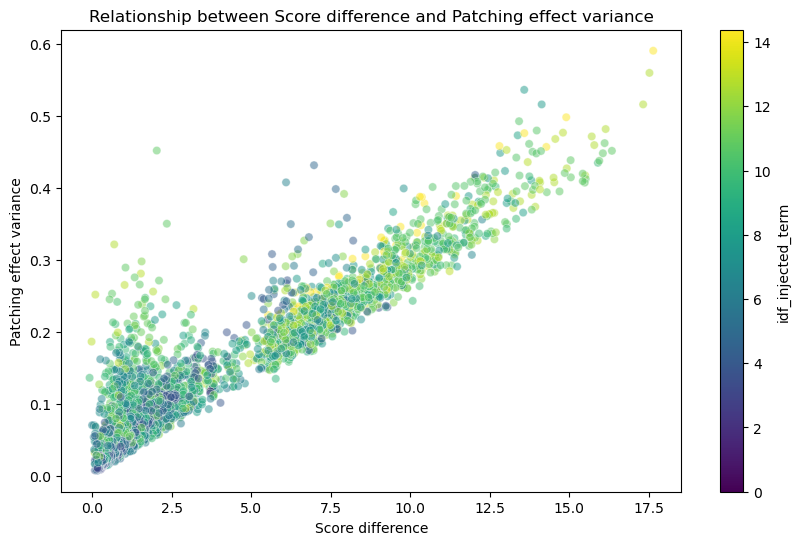

In [18]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'idf_injected_term', feature_table_dual_encoder, 'Relationship between Score difference and Patching effect variance', 'Score difference', 'Patching effect variance')

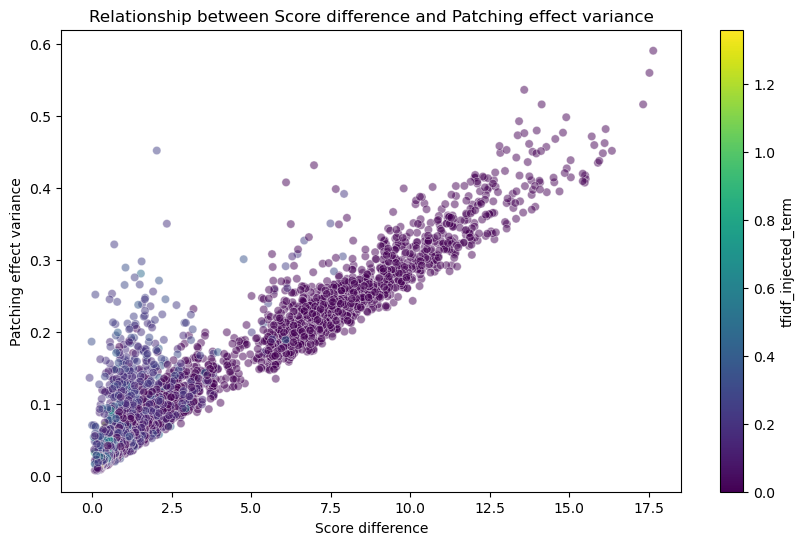

In [19]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'tfidf_injected_term', feature_table_dual_encoder, 'Relationship between Score difference and Patching effect variance', 'Score difference', 'Patching effect variance')

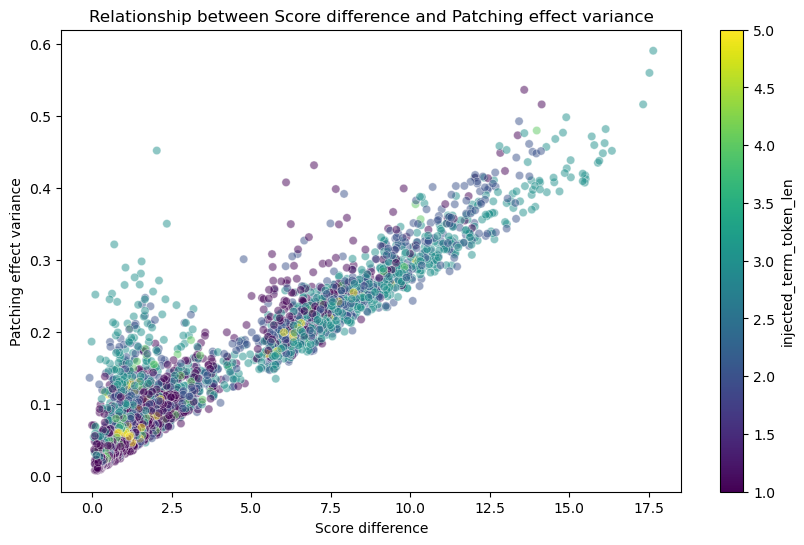

In [20]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_std', 'injected_term_token_len', feature_table_dual_encoder, 'Relationship between Score difference and Patching effect variance', 'Score difference', 'Patching effect variance')

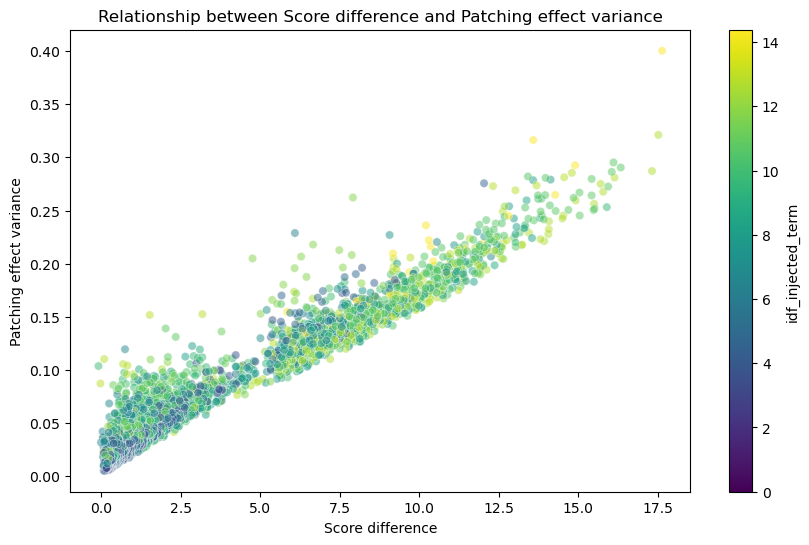

In [21]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_absolute_mean', 'idf_injected_term', feature_table_dual_encoder, 'Relationship between Score difference and Patching effect variance', 'Score difference', 'Patching effect variance')

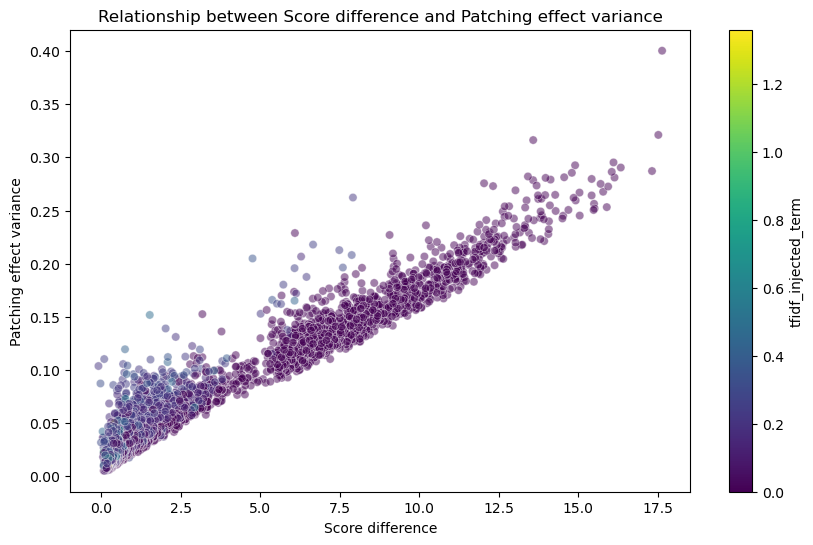

In [22]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_absolute_mean', 'tfidf_injected_term', feature_table_dual_encoder, 'Relationship between Score difference and Patching effect variance', 'Score difference', 'Patching effect variance')

Let's also try to fit CatBoost model on the normalised metric and on the decorrelated

In [23]:
from sklearn.linear_model import LinearRegression

def decorrelate_columns(df, target_col, feature_col, new_col_name=None):
    if new_col_name is None:
        new_col_name = f"{target_col}_decorrelated"

    model = LinearRegression()
    X = df[[feature_col]].values
    y = df[target_col].values
    model.fit(X, y)

    predicted = model.predict(X)

    df[new_col_name] = df[target_col] - predicted

    print(f"Correlation before: {df[target_col].corr(df[feature_col]):.4f}")
    print(f"Correlation after: {df[new_col_name].corr(df[feature_col]):.4f}")

    return df


def train_catboost_model(df, target_column, feature_columns):
    X = df[feature_columns]
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        early_stopping_rounds=20,
        verbose=100
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=True
    )
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance,
        'predictions': y_pred
    }

In [24]:
decorrelate_columns(feature_table_dual_encoder, 'patching_effect_absolute_mean', 'score_delta', new_col_name='patching_effect_absolute_mean_decorrelated')
decorrelate_columns(feature_table_dual_encoder, 'patching_effect_std', 'score_delta', new_col_name='patching_effect_std_decorrelated')
decorrelate_columns(feature_table_cross_encoder, 'patching_effect_absolute_mean', 'score_delta', new_col_name='patching_effect_absolute_mean_decorrelated')
decorrelate_columns(feature_table_cross_encoder, 'patching_effect_std', 'score_delta', new_col_name='patching_effect_std_decorrelated')

Correlation before: 0.9679
Correlation after: -0.0000
Correlation before: 0.9435
Correlation after: -0.0000
Correlation before: 0.9124
Correlation after: 0.0000
Correlation before: 0.9358
Correlation after: 0.0000


,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,...,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean,patching_effect_absolute_mean_decorrelated,patching_effect_std_decorrelated
0,855410,what is theraderm used for,7128710,It is used to trap sunlight for the manufactur...,0,True,4.990025,0,-8.083547,13.073571,...,0.700593,0.405368,0.053588,0.031007,0.053432,0.030916,0.053588,0.031007,0.133807,0.146108
1,855410,what is theraderm used for,3276027,"A mental grouping of similar things, events, a...",0,True,2.224426,30,-9.739095,11.963521,...,0.551984,0.281880,0.046139,0.023562,0.045979,0.023480,0.046139,0.023562,0.032880,0.044108
2,855410,what is theraderm used for,8751749,": to add moisture to (something, such as a per...",0,True,2.215183,26,-9.171948,11.387131,...,0.453133,0.248891,0.039793,0.021857,0.039641,0.021773,0.039793,0.021857,0.011606,-0.030542
3,855410,what is theraderm used for,2945339,1 used to form adjectives Resembling or imitat...,0,True,1.944622,38,-9.353897,11.298519,...,0.571451,0.276316,0.050578,0.024456,0.050381,0.024361,0.050578,0.024456,0.040832,0.091498
4,583468,what carvedilol used for,129686,Bottles of eau de toilette. Eau de toilette (F...,0,True,1.815684,226,-9.783665,11.599349,...,0.479556,0.261826,0.041343,0.022573,0.041191,0.022489,0.041343,0.022573,0.020229,-0.013029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,405163,is caffeine an narcotic,7339772,Combination or cocktail drugs that contain a c...,3,True,-4.867818,258,-5.073496,0.205678,...,0.016658,0.011814,0.080989,0.057438,0.016316,0.011572,0.080989,0.057438,0.001785,0.002469
3996,324585,how much money do motivational speakers make,405281,Fee structures for more experienced and profes...,3,True,2.870646,8,2.715543,0.155103,...,0.009705,0.006859,0.062570,0.044224,0.009590,0.006778,0.062570,0.044224,-0.002141,-0.002360
3997,1132532,average annual income data analyst,6117745,What Data Analysts Make. Since the field of da...,3,True,1.993316,69,1.944495,0.048821,...,0.007879,0.004875,0.161382,0.099858,0.007869,0.004869,0.156822,0.099157,-0.001965,0.000277
3998,1113256,what is reba mcentire's net worth,7561111,Reba McEntire is a popular American singer wit...,3,True,5.701837,7,5.690272,0.011565,...,0.002111,0.001500,0.182514,0.129679,0.002111,0.001500,0.182514,0.129679,-0.004583,-0.003927


Let's firstly do it for the dual encoder. I am training the CatBoost to predict the decorrelated magnitude, the normalised magnitude with penalty

In [25]:
results_mean = train_catboost_model(feature_table_dual_encoder, 'patching_effect_absolute_mean_decorrelated', features)

TBB Warning: The number of workers is currently limited to 15. The request for 63 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0146468	test: 0.0145369	best: 0.0145369 (0)	total: 50.4ms	remaining: 50.4s
100:	learn: 0.0082161	test: 0.0095931	best: 0.0095931 (100)	total: 172ms	remaining: 1.53s
200:	learn: 0.0067279	test: 0.0093583	best: 0.0093583 (200)	total: 292ms	remaining: 1.16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.009345312816
bestIteration = 208

Shrink model to first 209 iterations.


In [26]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f1afce436d0>,
 'rmse': 0.009345312783493799,
 'r2': 0.610100202537186,
 'feature_importance':                                feature  importance
 2                  tfidf_injected_term   20.080603
 0                          score_delta    9.769256
 4                     tf_injected_term    8.703768
 5              injected_term_token_len    7.406144
 3                    idf_injected_term    6.898706
 17                     tfidf_std_query    5.047874
 6                           tfidf_mean    4.992382
 1                            relevance    4.338529
 15                     gpt2_perplexity    3.421719
 11                          smog_index    3.205379
 7                            tfidf_std    3.139602
 20                   gunning_fog_query    2.422364
 19           flesch_reading_ease_query    2.334560
 22            coleman_liau_index_query    2.169617
 14        dale_chall_readability_score    2.105147
 9                  flesch

In [34]:
results_mean = train_catboost_model(feature_table_dual_encoder, 'patching_effect_normalised_square_absolute_mean', features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0084434	test: 0.0078389	best: 0.0078389 (0)	total: 2.23ms	remaining: 2.22s
100:	learn: 0.0039524	test: 0.0042885	best: 0.0042885 (100)	total: 117ms	remaining: 1.04s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.004191284229
bestIteration = 137

Shrink model to first 138 iterations.


In [35]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f1afca8e850>,
 'rmse': 0.004191284241786745,
 'r2': 0.7377514163597121,
 'feature_importance':                                feature  importance
 2                  tfidf_injected_term   21.309583
 0                          score_delta   21.178778
 4                     tf_injected_term   13.273315
 5              injected_term_token_len   12.413818
 3                    idf_injected_term    4.161404
 15                     gpt2_perplexity    3.245221
 6                           tfidf_mean    2.152841
 17                     tfidf_std_query    2.139690
 1                            relevance    2.054141
 18           english_probability_query    1.872901
 7                            tfidf_std    1.778152
 19           flesch_reading_ease_query    1.772330
 9                  flesch_reading_ease    1.713946
 20                   gunning_fog_query    1.662383
 11                          smog_index    1.608946
 25               gpt2_pe

In [27]:
results_mean = train_catboost_model(feature_table_dual_encoder_cut, 'patching_effect_normalised_square_absolute_mean', features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0025275	test: 0.0022062	best: 0.0022062 (0)	total: 2.62ms	remaining: 2.61s
100:	learn: 0.0009818	test: 0.0015275	best: 0.0015275 (100)	total: 90.8ms	remaining: 808ms
200:	learn: 0.0006429	test: 0.0014865	best: 0.0014861 (197)	total: 182ms	remaining: 723ms
300:	learn: 0.0004787	test: 0.0014700	best: 0.0014700 (300)	total: 270ms	remaining: 627ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001467975148
bestIteration = 306

Shrink model to first 307 iterations.


In [29]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f1afcd93ca0>,
 'rmse': 0.0014679751475216818,
 'r2': 0.5781958164489949,
 'feature_importance':                                feature  importance
 0                          score_delta   14.010267
 4                     tf_injected_term   10.454881
 3                    idf_injected_term    7.878180
 2                  tfidf_injected_term    7.394854
 11                          smog_index    5.151905
 22            coleman_liau_index_query    4.805096
 14        dale_chall_readability_score    4.351329
 9                  flesch_reading_ease    4.041388
 6                           tfidf_mean    3.721871
 19           flesch_reading_ease_query    3.619044
 20                   gunning_fog_query    3.548985
 7                            tfidf_std    3.323130
 15                     gpt2_perplexity    2.860069
 25               gpt2_perplexity_query    2.851535
 17                     tfidf_std_query    2.609406
 18           english_pr

In [30]:
results_std = train_catboost_model(feature_table_dual_encoder, 'patching_effect_std_decorrelated', features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0331855	test: 0.0327918	best: 0.0327918 (0)	total: 2.66ms	remaining: 2.65s
100:	learn: 0.0198195	test: 0.0223363	best: 0.0222973 (94)	total: 117ms	remaining: 1.04s
200:	learn: 0.0161237	test: 0.0215704	best: 0.0215704 (200)	total: 231ms	remaining: 919ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.02137337626
bestIteration = 247

Shrink model to first 248 iterations.


In [31]:
results_std

{'model': <catboost.core.CatBoostRegressor at 0x7f1afcbf98b0>,
 'rmse': 0.021373376317188757,
 'r2': 0.6022800394563865,
 'feature_importance':                                feature  importance
 2                  tfidf_injected_term   20.453234
 4                     tf_injected_term   11.114690
 0                          score_delta   11.008667
 3                    idf_injected_term    8.283012
 5              injected_term_token_len    6.111491
 17                     tfidf_std_query    4.680157
 19           flesch_reading_ease_query    3.512130
 7                            tfidf_std    2.953537
 22            coleman_liau_index_query    2.825662
 25               gpt2_perplexity_query    2.707930
 20                   gunning_fog_query    2.655008
 6                           tfidf_mean    2.548370
 12                  coleman_liau_index    2.455483
 1                            relevance    2.190069
 24  dale_chall_readability_score_query    2.029908
 9                  flesc

In [32]:
results_std = train_catboost_model(feature_table_dual_encoder, 'patching_effect_normalised_square_std', features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0199372	test: 0.0197293	best: 0.0197293 (0)	total: 2.16ms	remaining: 2.15s
100:	learn: 0.0101134	test: 0.0123117	best: 0.0123117 (100)	total: 119ms	remaining: 1.06s
200:	learn: 0.0080087	test: 0.0120494	best: 0.0120494 (200)	total: 242ms	remaining: 961ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.01202508029
bestIteration = 228

Shrink model to first 229 iterations.


In [33]:
results_std

{'model': <catboost.core.CatBoostRegressor at 0x7f1afcc89e80>,
 'rmse': 0.012025080246051352,
 'r2': 0.6533031120823884,
 'feature_importance':                                feature  importance
 2                  tfidf_injected_term   21.242290
 0                          score_delta   16.771910
 4                     tf_injected_term   14.835662
 5              injected_term_token_len    6.643859
 3                    idf_injected_term    6.248122
 19           flesch_reading_ease_query    3.347424
 20                   gunning_fog_query    3.266002
 7                            tfidf_std    2.689814
 15                     gpt2_perplexity    2.634684
 12                  coleman_liau_index    2.170588
 17                     tfidf_std_query    2.122064
 16                    tfidf_mean_query    2.044115
 24  dale_chall_readability_score_query    1.961968
 6                           tfidf_mean    1.904576
 9                  flesch_reading_ease    1.724498
 22            coleman_li

Let's also do this with the cross encoder

In [50]:
results_mean = train_catboost_model(feature_table_cross_encoder, 'patching_effect_absolute_mean_decorrelated', features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0276271	test: 0.0309875	best: 0.0309875 (0)	total: 2.11ms	remaining: 2.11s
100:	learn: 0.0191757	test: 0.0280415	best: 0.0280200 (94)	total: 117ms	remaining: 1.04s
200:	learn: 0.0145128	test: 0.0275109	best: 0.0274749 (190)	total: 231ms	remaining: 917ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.02747488197
bestIteration = 190

Shrink model to first 191 iterations.


In [51]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f1afca15850>,
 'rmse': 0.027474881903996377,
 'r2': 0.23487759934589147,
 'feature_importance':                                feature  importance
 0                          score_delta   22.179986
 15                     gpt2_perplexity    9.263302
 5              injected_term_token_len    6.963903
 9                  flesch_reading_ease    6.278900
 1                            relevance    5.747368
 3                    idf_injected_term    4.972491
 6                           tfidf_mean    4.615177
 7                            tfidf_std    4.396555
 12                  coleman_liau_index    4.376082
 8                  english_probability    3.773743
 14        dale_chall_readability_score    3.708378
 10                         gunning_fog    2.858190
 19           flesch_reading_ease_query    2.817267
 13         automated_readability_index    2.765564
 24  dale_chall_readability_score_query    2.414535
 16                    t

In [52]:
results_mean = train_catboost_model(feature_table_cross_encoder, 'patching_effect_normalised_square_absolute_mean', features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0070127	test: 0.0077028	best: 0.0077028 (0)	total: 1.83ms	remaining: 1.83s
100:	learn: 0.0039436	test: 0.0057418	best: 0.0057376 (95)	total: 116ms	remaining: 1.03s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.005734735678
bestIteration = 109

Shrink model to first 110 iterations.


In [53]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f1af7ab88e0>,
 'rmse': 0.005734735666528138,
 'r2': 0.48197488654725684,
 'feature_importance':                                feature  importance
 0                          score_delta   39.295055
 5              injected_term_token_len    9.717070
 1                            relevance    8.015121
 3                    idf_injected_term    6.011050
 17                     tfidf_std_query    4.483726
 6                           tfidf_mean    4.452713
 15                     gpt2_perplexity    3.619795
 16                    tfidf_mean_query    3.093335
 24  dale_chall_readability_score_query    2.333225
 19           flesch_reading_ease_query    2.288708
 12                  coleman_liau_index    1.787864
 14        dale_chall_readability_score    1.712424
 20                   gunning_fog_query    1.710267
 9                  flesch_reading_ease    1.700114
 22            coleman_liau_index_query    1.663696
 4                     t

In [54]:
results_mean = train_catboost_model(feature_table_cross_encoder_cut, 'patching_effect_normalised_square_absolute_mean', features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0064122	test: 0.0063226	best: 0.0063226 (0)	total: 1.28ms	remaining: 1.28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.005753629436
bestIteration = 76

Shrink model to first 77 iterations.


In [55]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f1afce41940>,
 'rmse': 0.005753629441474124,
 'r2': 0.17988260385941268,
 'feature_importance':                                feature  importance
 15                     gpt2_perplexity   10.121407
 5              injected_term_token_len    9.831616
 12                  coleman_liau_index    8.841402
 14        dale_chall_readability_score    6.208340
 0                          score_delta    5.957521
 25               gpt2_perplexity_query    5.381726
 16                    tfidf_mean_query    5.278454
 24  dale_chall_readability_score_query    5.213792
 17                     tfidf_std_query    4.556319
 1                            relevance    3.951750
 18           english_probability_query    3.797641
 19           flesch_reading_ease_query    3.635218
 7                            tfidf_std    3.510996
 13         automated_readability_index    3.434931
 22            coleman_liau_index_query    3.413713
 23   automated_readabil